In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from scipy import interpolate

from astropy import constants as const
from astropy import units as u

import extinction

from plotting_spectra import *

#plt.style.use('dark_background')

rc_params = {
    'lines.linewidth': 2,  # Set line width to 2 points
    'font.family': 'STIXGeneral',  # Set color cycle for axes
    'ytick.direction': 'in',  # Set figure size in inches
    'xtick.direction': 'in',  # Set default font family
}

plt.rcParams.update(rc_params)

In [4]:
# Here the lightcurves are loaded
lightcurves_alercextns = pd.read_pickle('./data/lightcurves/lcs_transients_20240517.pkl')
#lightcurves_alercextns

In [5]:
# Load all spectra info, metadata and data.
spectra_metadata = pd.read_csv('wiserep_spectra_metadata.csv', low_memory=False)
spectra_data     = pd.read_pickle('spectra_ALeRCE20240704_x_wisrep_20240622.pkl')

In [45]:
spectra_data['snname'].value_counts()[spectra_data['snname'].value_counts() < 5].index

Index(['SN2021fl', 'SNLS-04D1aj', 'SN1996cc', 'SN2022abw', 'SN2020py',
       'SN2021rf', 'SN2019rz', 'SN2000N', 'SN2022qo', 'SN2007as',
       ...
       'SN2023rno', 'SN2022acqz', 'SN2022gjq', 'SN2022cjv', 'SN2019mom',
       'SN2019vsa', 'SN2023ddy', 'SN2021mvm', 'iPTF14gjh', 'PTF12edl'],
      dtype='object', name='snname', length=15795)

In [41]:
spectra_data.snname.unique()

array(['SN2022pru', 'SN2022ytx', 'SNLS-07D3do', ..., 'SN2020oqp',
       'SDSS-SN-082', 'PTF12edl'], dtype=object)

In [ ]:
rare_supernova = spectra_metadata[spectra_metadata['IAU name'] == 'SN 2022qzr']
rare_supernova['Lambda-min']

In [ ]:
rare_supernova['Spec. units']

In [ ]:
# usar el percentil 10 de los minimos
# Usar el percentil 90 de las maximos

spectra_data.lambda_data_min.quantile(0.1)

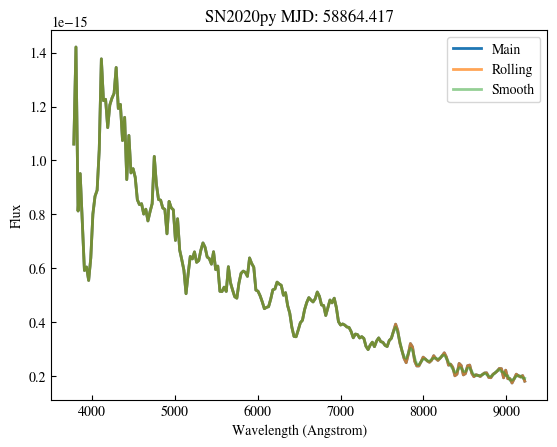

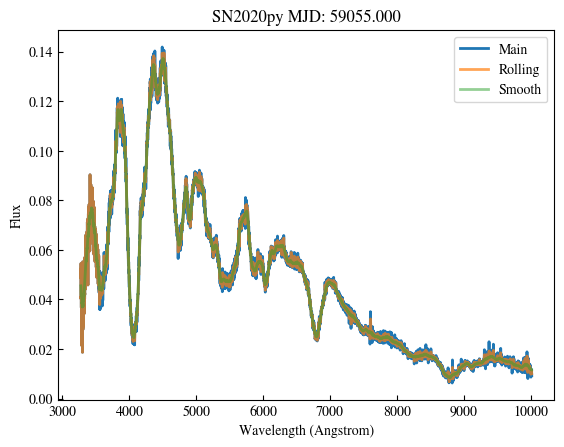

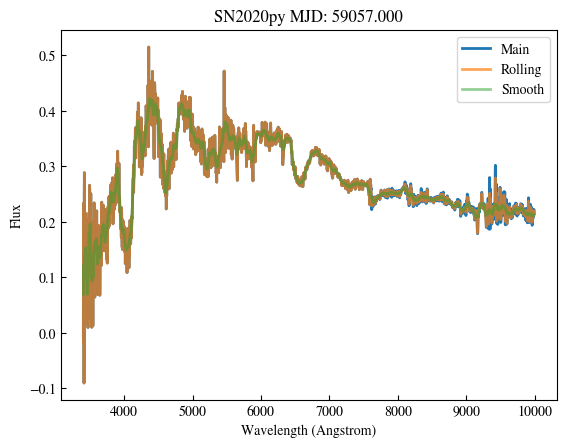

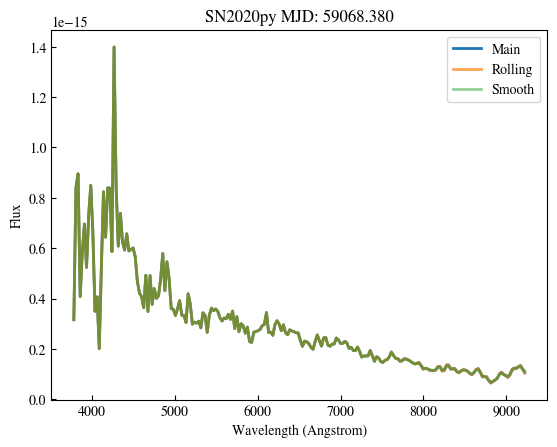

In [48]:
CSPEED = 3e5 # light_speed in km/s
dv = 200
dvsmooth = 2000
dlog10lambda = dv / CSPEED / np.log(10) * (24 * 3600) # pseudo seconds
dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

sn_name = 'SN2020py'
raw_spectra = pd.read_csv(f'./data/spectra_wiserep/{sn_name}.dat')
for group_name, group in raw_spectra.groupby('mjd'):
    fig, ax = plt.subplots()
    wave = group['lambda'].to_numpy()

    group["log10lambda"] = np.log10(wave)

    # fool pandas to make it think log10lambda is days
    group["log10lambda_idx"] = group["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
    group.set_index("log10lambda_idx", inplace=True)

    # sorting the index
    group = group.sort_index()

    # obtain the flux rolled of the log_lambda
    group["flux_log10lambda_rolling"] = group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
    #delta = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    group["eflux_log10lambda_rolling"] = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()

    flux = group['flux_lambda'].to_numpy()
    ax.plot(wave, flux, label='Main')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()), alpha=0.7, label='Rolling')
    ax.plot(wave, np.array(group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()), alpha=0.5, label='Smooth')
    #ax.plot(wave, group['eflux_log10lambda_rolling'].to_numpy())
    ax.set_title(f'{sn_name} MJD: {group_name:.3f}')
    ax.set_xlabel('Wavelength (Angstrom)')
    ax.set_ylabel('Flux')
    ax.legend()

In [7]:
raw_spectra["log10lambda"] = raw_spectra['lambda'].apply(lambda x: np.log10(x))
raw_spectra["log10lambda_idx"] = raw_spectra["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
result = []
for name, group in raw_spectra.groupby('mjd'):
    group = group.set_index('log10lambda_idx').sort_index()
    group["flux_log10lambda_rolling"] = group.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
    group["eflux_log10lambda_rolling"] = (group.flux_log10lambda_rolling - group.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    result.append(group)

# Concatenar los grupos procesados
raw_spectra = pd.concat(result)
raw_spectra.reset_index(inplace=True)
raw_spectra = raw_spectra.drop('log10lambda_idx',axis=1)
raw_spectra


,mjd,lambda,flux_lambda,e_flux_lambda,instrument,log10lambda,flux_log10lambda_rolling,eflux_log10lambda_rolling
0,59231.401400,3776.700000,2.925000e-16,2.636000e-32,P60_SEDM_TNS.ascii,3.577112,2.925000e-16,NaN
1,59231.401400,3802.300000,4.110000e-16,2.499000e-32,P60_SEDM_TNS.ascii,3.580046,4.110000e-16,NaN
2,59231.401400,3827.900000,5.095000e-16,1.663000e-32,P60_SEDM_TNS.ascii,3.582961,5.095000e-16,NaN
3,59231.401400,3853.400000,6.237000e-16,7.386000e-33,P60_SEDM_TNS.ascii,3.585844,6.237000e-16,NaN
4,59231.401400,3879.000000,5.418000e-16,1.575000e-32,P60_SEDM_TNS.ascii,3.588720,5.418000e-16,NaN
...,...,...,...,...,...,...,...,...
3338,59316.267183,9223.155745,1.366769e-17,NaN,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,3.964880,1.366769e-17,7.057374e-18
3339,59316.267183,9228.673673,5.417091e-18,NaN,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,3.965139,5.417091e-18,7.410052e-18
3340,59316.267183,9234.191601,1.087436e-17,NaN,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,3.965399,1.087436e-17,7.914589e-18
3341,59316.267183,9239.709529,1.760946e-17,NaN,ESO-NTT_EFOSC2-NTT_ePESSTOp.asci,3.965658,1.760946e-17,8.252335e-18


In [ ]:
raw_spectra["log10lambda"] = np.log10(raw_spectra['lambda'])

# fool pandas to make it think log10lambda is days
raw_spectra["log10lambda_idx"] = raw_spectra["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
raw_spectra.set_index("log10lambda_idx", inplace=True)
print(raw_spectra)
# sorting the index
#raw_spectra = raw_spectra.sort_index()

# obtain the flux rolled of the log_lambda
raw_spectra["flux_log10lambda_rolling"] = raw_spectra.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
#delta = (raw_spectra.flux_log10lambda_rolling - raw_spectra.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
raw_spectra["eflux_log10lambda_rolling"] = (raw_spectra.flux_log10lambda_rolling - raw_spectra.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()


In [ ]:
def smooth_flux(data:pd.DataFrame, dv:float = 200, dvsmooth:float = 2000) -> pd.DataFrame:
    """
    
    Params
    ------
    data: pd.DataFrame with the spectra data
    dv: velocity 

    Return
    ------
    pd.Dataframe mainly flux rolled of the log_lambda
    """

    CSPEED = 3e5 # light_speed in km/s

    dlog10lambda = dv / CSPEED / np.log(10) * (24 * 3600) # pseudo seconds
    dlog10lambdasmooth = dvsmooth / CSPEED / np.log(10) * 24 * 3600 # pseudo seconds

    data["log10lambda"] = np.log10(data["lambda"])

    # fool pandas to make it think log10lambda is days
    data["log10lambda_idx"] = data["log10lambda"].apply(lambda x: pd.Timedelta(x, 'days'))
    data.set_index("log10lambda_idx", inplace=True)

    # sorting the index
    data = data.sort_index()
    
    # obtain the flux rolled of the log_lambda
    data["flux_log10lambda_rolling"] = data.flux_lambda.rolling(f'{int(dlog10lambda)}s', center=True).mean()
    #delta = (data.flux_log10lambda_rolling - data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    data["eflux_log10lambda_rolling"] = (data.flux_log10lambda_rolling - data.flux_lambda.rolling(f'{int(dlog10lambdasmooth)}s', center=True).mean()).rolling(f'{int(dlog10lambdasmooth)}s', center=True).std()
    
    # erase the indexing
    data.reset_index(inplace=True)
    data = data.drop('log10lambda_idx',axis=1)
    
    return data

In [8]:
def arrange_spectra(sn_name:str,data: pd.DataFrame,oid:int,
                    lambda_grid:np.array, nlambda_grid: int) -> pd.DataFrame:
    results = []
    #for inst_name, inst_group in data.groupby('instrument'):
    for mjd, mjd_group in data.groupby('mjd'):
        #flux_lambda = obtain_interpolated_flux(data=data, lambda_grid=lambda_grid)
        
        #flux_lambda, eflux_lambda

        data_flux = {
            'oid': oid,
            'snname':sn_name,
        #   'instrument': inst_name,
            'mjd': mjd,
            'lambda_grid_min': lambda_grid.min(),
            'lambda_grid_max': lambda_grid.max(),
            'nlambda_grid': nlambda_grid,
            'lambda_data_min': mjd_group['lambda'].min(),
            'lambda_data_max': mjd_group['lambda'].max(),
            'flux_lambda': np.array(mjd_group.flux_log10lambda_rolling),
            'e_flux_lambda': np.array(mjd_group.eflux_log10lambda_rolling)}
        results.append(data_flux)

        oid += 1

    unique_table = pd.DataFrame(results)
    return unique_table, oid

In [9]:
wavelength_lsst = {
    'u': [3206.34, 4081.51],
    'g': [3876.02, 5665.33],
    'r': [5377.19, 7055.16],
    'i': [6765.77, 8325.05],
    'z': [8035.39, 9375.47],
    'y': [9089.07, 10915.01]
}

# Obtain the min and max values of the LSST's wavelength
wavelength_grid_min = min([wavelength for wavelength_list in wavelength_lsst.values() for wavelength in wavelength_list])
wavelength_grid_max = max([wavelength for wavelength_list in wavelength_lsst.values() for wavelength in wavelength_list])

print(f'The min wavelength value to create the grid is: {wavelength_grid_min:.2f} Angstrom')
print(f'The max wavelength value to create the grid is: {wavelength_grid_max:.2f} Angstrom')

# Number grid's bins
nwavelength_grid = 1838

# Array equal spacing of wavelengths 
wavelength_grid_array = np.logspace(np.log10(wavelength_grid_min),np.log10(wavelength_grid_max),nwavelength_grid)

The min wavelength value to create the grid is: 3206.34 Angstrom
The max wavelength value to create the grid is: 10915.01 Angstrom


In [10]:
master_dataframe = pd.DataFrame()

oid = 1
sn_name = 'SN2021gd'
data = raw_spectra
result_table, oid = arrange_spectra(sn_name,data,oid, wavelength_grid_array, nwavelength_grid)
master_dataframe = pd.concat([master_dataframe, result_table])

In [11]:
spectrum = master_dataframe
spectrum

,oid,snname,mjd,lambda_grid_min,lambda_grid_max,nlambda_grid,lambda_data_min,lambda_data_max,flux_lambda,e_flux_lambda
0,1,SN2021gd,59231.401400,3206.34,10915.01,1838,3776.70000,9223.300000,"[2.925e-16, 4.11e-16, 5.095e-16, 6.237e-16, 5....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2,SN2021gd,59292.354051,3206.34,10915.01,1838,3776.70000,9223.300000,"[9.435e-16, 7.731e-16, 8.137e-16, 9.954e-16, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,3,SN2021gd,59293.367245,3206.34,10915.01,1838,3402.86000,9099.860000,"[1.726054e-16, 1.71431e-16, 1.904138e-16, 1.86...","[1.0035616718011578e-17, 1.0350189959934039e-1..."
3,4,SN2021gd,59316.267183,3206.34,10915.01,1838,3650.04834,9245.227457,"[2.4332964e-17, 2.4602027e-17, 5.0554057e-18, ...","[9.447324842906821e-18, 8.041415192762354e-18,..."


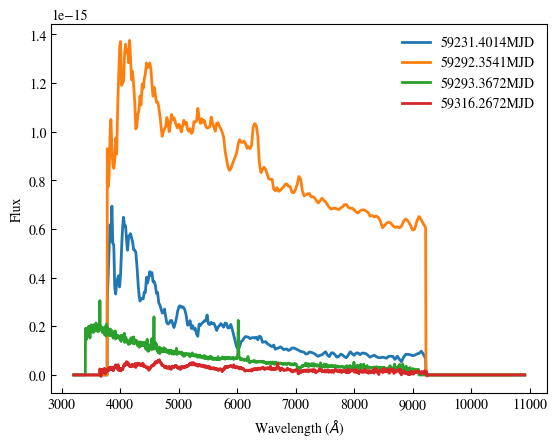

In [12]:
plot_spectra(spectrum, use_lambda_grid=True)

In [13]:
objective_ligtcurve = lightcurves_alercextns[lightcurves_alercextns.oid == 'ZTF21aaahtln']
#objective_ligtcurve

In [14]:
wavelength_lsst = {'u':[3206.34, 4081.51], 'g':[3876.02, 5665.33], 'r':[5377.19, 7055.16],
                   'i':[6765.77, 8325.05], 'z':[8035.39, 9375.47], 'y':[9089.07, 10915.01]}

wavelength_ztf ={'g':[3676.00, 5613.82], 'r':[5497.60, 7394.40], 'i':[6870.97, 8964.61],}

ztf_sv_files  = [file for file in os.listdir('./data/') if 'Palomar' in file]
lsst_sv_files = [file for file in os.listdir('./data/') if 'LSST' in file]

ztf_sv_dict  = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in ztf_sv_files}
lsst_sv_dict = {file.split('.')[1]: np.loadtxt(fname=f'./data/{file}') for file in lsst_sv_files}

In [ ]:
#grouped = raw_spectra.groupby('mjd').agg(list).reset_index()
#grouped

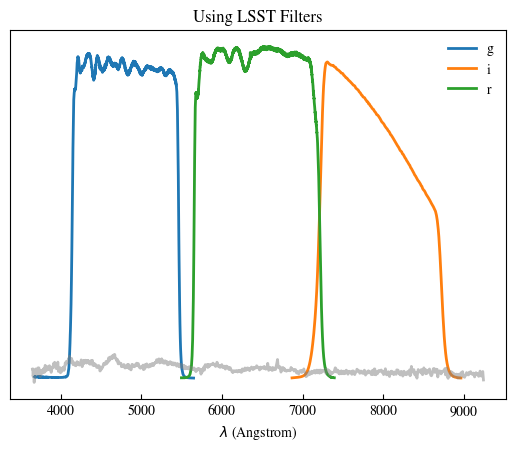

In [15]:
idx_spec = 3
fig, ax = plt.subplots()
#x_spectrum = np.array(spectrum.iloc[idx_spec]['lambda_'])

x_spectrum = np.logspace(np.log10(spectrum.iloc[idx_spec].lambda_data_min),np.log10(spectrum.iloc[idx_spec].lambda_data_max),len(spectrum.iloc[idx_spec].flux_lambda))
y_spectrum = np.array((spectrum.iloc[idx_spec]['flux_lambda'])) * 1e15

for band, sv in ztf_sv_dict.items():
    x, y = zip(*ztf_sv_dict[band])
    ax.plot(x,y,label=f'{band}')
ax.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
ax.set_xlabel(r'$\lambda$ (Angstrom)')
ax.set_yticklabels([])
ax.set_yticks([])
ax.set_title('Using LSST Filters')
ax.legend(frameon=False)

plt.show()

In [32]:
spectrum = raw_spectra.groupby('mjd').agg(list).reset_index()
spectrum

,mjd,lambda,flux_lambda,e_flux_lambda,instrument,log10lambda,flux_log10lambda_rolling,eflux_log10lambda_rolling
0,59231.401400,"[3776.7, 3802.3, 3827.9, 3853.4, 3879.0, 3904....","[2.925e-16, 4.11e-16, 5.095e-16, 6.237e-16, 5....","[2.636e-32, 2.499e-32, 1.663e-32, 7.386e-33, 1...","[P60_SEDM_TNS.ascii, P60_SEDM_TNS.ascii, P60_S...","[3.577112488264347, 3.5800463795479898, 3.5829...","[2.925e-16, 4.11e-16, 5.095e-16, 6.237e-16, 5....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,59292.354051,"[3776.7, 3802.3, 3827.9, 3853.4, 3879.0, 3904....","[9.435e-16, 7.731e-16, 8.137e-16, 9.954e-16, 1...","[3.3e-32, 3.352e-32, 1.771e-32, 2.227e-32, 2.6...","[P60_SEDM_TNS.ascii, P60_SEDM_TNS.ascii, P60_S...","[3.577112488264347, 3.5800463795479898, 3.5829...","[9.435e-16, 7.731e-16, 8.137e-16, 9.954e-16, 1...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,59293.367245,"[3402.86, 3405.86, 3408.86, 3411.86, 3414.86, ...","[1.726054e-16, 1.71431e-16, 1.904138e-16, 1.86...","[1.454341e-17, 1.5128150000000002e-17, 1.39579...","[UH88_SNIFS_TNS.dat, UH88_SNIFS_TNS.dat, UH88_...","[3.531844081779269, 3.5322267920478723, 3.5326...","[1.726054e-16, 1.71431e-16, 1.904138e-16, 1.86...","[1.0035616718011578e-17, 1.0350189959934039e-1..."
3,59316.267183,"[3650.04833984375, 3655.566267967224, 3661.084...","[2.4332964e-17, 2.4602027e-17, 5.0554057e-18, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[ESO-NTT_EFOSC2-NTT_ePESSTOp.asci, ESO-NTT_EFO...","[3.562298616124524, 3.5629546611857292, 3.5636...","[2.4332964e-17, 2.4602027e-17, 5.0554057e-18, ...","[9.447324842906821e-18, 8.041415192762354e-18,..."


In [16]:
def obtain_magnitude_flux(spectrum:pd.DataFrame,instrument:str) -> dict:

    CSPEED = 3e8 # m/s

    if instrument == 'ztf':
        tranmision_dict = ztf_sv_dict
    elif instrument ==  'lsst':
        tranmision_dict = lsst_sv_dict

    #x_spectrum = np.linspace(spectrum.lambda_data_min,spectrum.lambda_data_max,len(spectrum.flux_lambda))
    x_spectrum = np.array(spectrum['lambda'])
    y_spectrum = np.array(spectrum.flux_log10lambda_rolling)
    f = interpolate.interp1d(x_spectrum,y_spectrum, fill_value=np.nan, bounds_error=False)

    mags = {}   
    for band, s_wave in tranmision_dict.items():
        band, s_wave = band,s_wave
        wave, s_wave = zip(*tranmision_dict[band])
        wave, s_wave = np.array(wave), np.array(s_wave)

        #condition = np.where((min(wave) < x_spectrum) & (max(wave) > x_spectrum))
        #x = x_spectrum[condition]
        #y = y_spectrum[condition]
        
        flux_wave_new = f(wave)

        log_nu = -np.log(wave)                           # Obtaining log_nu in lambda termns
        f_nu   = (wave**2/(CSPEED*1e10)) * flux_wave_new # Obtaining f_nu in lambda termns
        s_nu   = s_wave 

        num = np.trapz(f_nu*s_nu, dx=log_nu[:-1])
        den = np.trapz(s_nu, dx=log_nu[:-1])
        #num_test = simple_integration(wave,f_nu*s_nu, log_nu)
        #den_test = simple_integration(wave,s_nu, log_nu)
        #m = -2.5 * np.log10(num_test/den_test) - 48.60
        m = -2.5 * np.log10(num/den) - 48.60
        mags.update({band:m})
    print(mags)
    return mags

In [17]:
spectrum = raw_spectra

In [ ]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ax = plt.subplots()
for _, row in spectrum.iterrows():
    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax.scatter(x=group.mjd, y=group.magpsf, color=color)
        ax.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color='C8')
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    try:
        magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    except:
        continue
    for bandapass, magnitude in magnitude_integrated.items():
        ax.scatter(row.mjd,magnitude)
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            #label = 
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax.legend(handles, bands, loc='lower right',frameon=False)
    ax.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax.add_artist(leg2)

    ax.yaxis.set_inverted(True)
    ax.set_xlabel('MJD')
    ax.set_ylabel('Apparent magnitude')
    ax.set_title(f'Light Curve {oid}')

In [25]:
redshift = spectra_metadata[spectra_metadata['IAU name'] == 'SN 2021gd']['Redshift'].iloc[0]

{'g': nan, 'i': 18.2098386953379, 'r': 17.95973264903855}
{'g': nan, 'i': 15.965973067440267, 'r': 16.09369620511361}
{'g': 18.913017378427035, 'i': 19.16127825656087, 'r': 18.951696885561923}
{'g': 20.232650487097338, 'i': 19.982244239705444, 'r': 19.867923506643415}


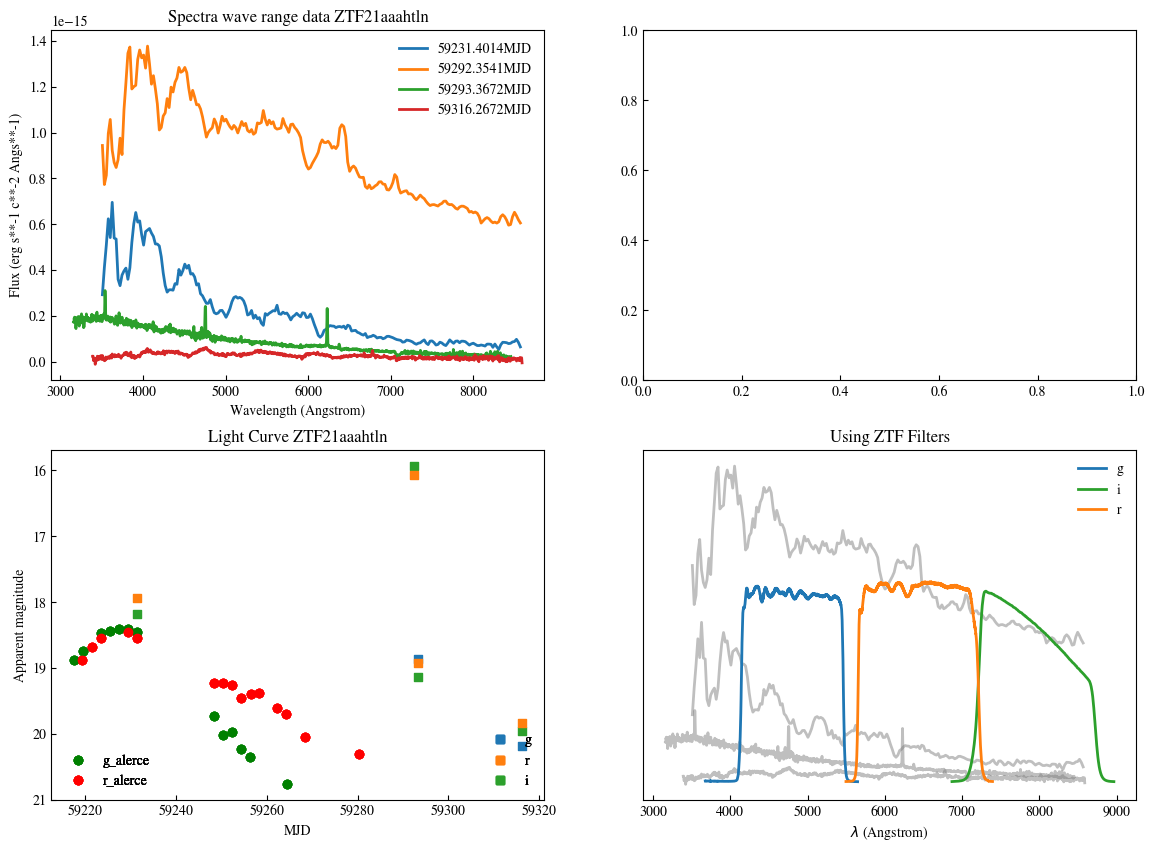

In [38]:
instrument = 'ztf'
if instrument == 'ztf':
    colors = ['C0','C1','C2']
    bands = ['g','r','i']
else:
    colors = ['C0','C1','C2','C3','C4','C5']
    bands = ['u','g','r','i','z','y']

wave = np.array([4746.48, 6366.38])

fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(14, 10))
oid = 'ZTF21aaahtln'
for _, row in spectrum.iterrows():

    # This calculate the x-axis and y-axis of the spectrum
    #x_spectrum = np.linspace(row.lambda_data_min/(1+correction_redshift),row.lambda_data_max/(1+correction_redshift), len(row.flux_lambda))
    x_spectrum = np.array(row['lambda'])/(1+redshift)
    y_spectrum = row.flux_log10lambda_rolling

    #x_spectrum_grid = np.linspace(row.lambda_grid_min,row.lambda_grid_max, row.nlambda_grid)
    #y_spectrum_grid = interpolate_flux(row)

    ax0.plot(x_spectrum, y_spectrum,label=f'{row.mjd:.4f}MJD')
    ax0.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    ax0.set_xlabel('Wavelength (Angstrom)')
    #ax1.text(x=max(x_spectrum)-500,
    #                 y=max(y_spectrum*2),
    #                 s=f'{row.mjd:.4f}MJD')
    ax0.set_title(f'Spectra wave range data {oid}')
    ax0.legend(frameon=False)

    #ax1.plot(x_spectrum_grid, y_spectrum_grid,label=f'{row.mjd:.4f}MJD')
    #ax1.set_ylabel('Flux (erg s**-1 c**-2 Angs**-1)')
    #ax1.set_xlabel('Wavelength (Angstrom)')
    #ax1.set_title(f'Spectra wave range grid {oid}')
    #ax1.legend(frameon=False)

    for group_name, group in objective_ligtcurve.groupby('fid'):
        color = 'green' if group_name == 1 else 'red'
        extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if group_name == 1 else extinction.ccm89(wave, 0.0375, 3.1)[1]
        ax2.scatter(x=group.mjd, y=group.magpsf - extinction_correction, color=color)
        
    # This calculate the magnitude of the spectrum based on
    # the integration of the flux
    
    magnitude_integrated = obtain_magnitude_flux(spectrum=row, instrument=instrument)
    for bandapass, magnitude in magnitude_integrated.items():
        if instrument == 'ztf':
            color = colors[0] if 'g' in bandapass else colors[1] if 'r' in bandapass else colors[2]
            extinction_correction = extinction.ccm89(wave, 0.0375, 3.1)[0] if 'g' in bandapass else extinction.ccm89(wave, 0.0375, 3.1)[1]
            #label = 
            ax2.scatter(row.mjd,magnitude - extinction_correction, marker='s',color = color)
        else: 
            color = colors[0] if 'u' in bandapass else colors[1] if 'g' in bandapass else colors[2] if 'r' in bandapass else colors[3] if 'i' in bandapass else colors[4] if 'z' in bandapass else colors[5]
            ax2.scatter(row.mjd,magnitude, marker='s',color = color)
    
    handles = [mlines.Line2D([], [], c=color, marker='s',ls='') for color in colors]
    leg1 = ax2.legend(handles, bands, loc='lower right',frameon=False)
    ax2.add_artist(leg1)
    handles = [mlines.Line2D([], [], c=color, marker='o',ls='') for color in ['g', 'r']]
    leg2 = ax2.legend(handles, ['g_alerce', 'r_alerce'], loc='lower left',frameon=False)
    ax2.add_artist(leg2)

    ax2.yaxis.set_inverted(True)
    ax2.set_xlabel('MJD')
    ax2.set_ylabel('Apparent magnitude')
    ax2.set_title(f'Light Curve {oid}')


    #x_spectrum = np.linspace(spectrum.iloc[idx_spec].lambda_data_min,spectrum.iloc[idx_spec].lambda_data_max,len(spectrum.iloc[idx_spec].flux_lambda))
    #y_spectrum = np.array(spectrum.iloc[idx_spec].flux_lambda)*1e15
    x_spectrum = np.array(row['lambda'])/(1+0.076427)
    y_spectrum = np.array(row.flux_lambda) *1e15
    ax3.plot(x_spectrum, y_spectrum, alpha = 0.5, color='gray')
for band, sv in ztf_sv_dict.items():
    color = 'C0' if band == 'g' else 'C1' if band == 'r' else 'C2'
    x, y = zip(*ztf_sv_dict[band])
    ax3.plot(x,y,label=f'{band}', color=color)
ax3.set_xlabel(r'$\lambda$ (Angstrom)')
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_title('Using ZTF Filters')
ax3.legend(frameon=False)
plt.show()

In [ ]:
def obtain_lambda_grid(df:pd.Series) -> list[float]:

    lambda_grid = np.logspace(start=np.log10(df.lambda_grid_min),
                stop=np.log10(df.lambda_grid_max),
                num=df.nlambda_grid)

    return lambda_grid

In [ ]:
def interpolate_flux(df:pd.Series) -> list[float]:
    
    lambda_grid = obtain_lambda_grid(df)
    
    flux = np.array(df.flux_lambda)
    lambda_data = np.logspace(start=np.log10(df.lambda_data_min),
                stop=np.log10(df.lambda_data_max),
                num=len(flux))

    f = interpolate.interp1d(lambda_data, flux, fill_value=np.nan, bounds_error=False)
    flux_new = f(lambda_grid)

    return flux_new 


In [ ]:
def simpler_intergrate(x:list[float],y:list[float]) -> float:
    
    y = np.nan_to_num(y, nan=0.0)
    
    integral = 0
    
    LSUN = const.L_sun

    for i in range(1,len(x)):
        delta_x = x[i] - x[i-1]
        integral += y[i-1] * delta_x

    return integral

In [ ]:
def obtain_luminosity_condition(df:pd.Series, instrument:str):

    lambda_grid = obtain_lambda_grid(df)
    flux = interpolate_flux(df)

    luminosity_list = []

    if instrument == 'ztf':
        bandpasses = ['g','r','i']

        for bandpass in bandpasses:
            condition = np.where((wavelength_ztf[bandpass][0] < lambda_grid) & (wavelength_ztf[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))
            

    elif instrument == 'lsst':
        bandpasses = ['u','g','r','i','z','y']

        for bandpass in bandpasses:
            condition = np.where((wavelength_lsst[bandpass][0] < lambda_grid) & (wavelength_lsst[bandpass][1] > lambda_grid))
            x = lambda_grid[condition]
            y = flux[condition]
            #y = convert_flux2mag(y)
            luminosity = simpler_intergrate(x, y)
            luminosity_list.append(luminosity)

        return dict(zip(bandpasses, luminosity_list))

    else:
        return print('There is not that instrument in list')

In [ ]:


# Av = 0.0375

Calcualte the magnitud

https://articles.adsabs.harvard.edu/pdf/1996AJ....111.1748F

In [ ]:
def simple_integration(x:list[float],y:list[float],delta_x:list[float]) -> float:
    y = np.nan_to_num(y, nan=0.0)

    if delta_x == None:
        delta_x = x[i] 

    integral = 0
    for i in range(len(delta_x)-1):
        integral += (y[i] + y[i+1]) * delta_x[i] / 2.0
    return integral